# Notebook 32: Assigning SFR and [Fe/H] to galaxies sampled from the GSMF

This notebook generates the galaxy grid file used in de Sá, Rocha et al. (2024).

## Prelude

In [1]:
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from pathlib import Path

import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm

import sys
sys.path.append('..')
from src.sfh import GSMF
from src.sampling import GalaxyGrid
from src.utils import ZOH_to_FeH, ZOH_to_FeH2, ZOH_from_FeH, FeH_to_Z
from src.constants import LOGE, LN10, GALAXYGRID_DIR_PATH

In [2]:
#plt.style.use('./plotstyle.mplstyle')
FIGURE_FOLDER = Path('./figures')

In [3]:
llim_feh = -2.25
ulim_feh = 0.45
llim_zoh = ZOH_from_FeH(llim_feh)
ulim_zoh = ZOH_from_FeH(ulim_feh)

In [4]:
logm_min = 6
logm_max = 12

In [5]:
highmet_MZR = 'KK04'
highmet_SFMR = 'none'
highmet_GSMF_fixedslope =  True

midmet_MZR = 'M09'
midmet_SFMR = 'moderate'
midmet_GSMF_fixedslope =  True

lowmet_MZR = 'PP04'
lowmet_SFMR = 'sharp'
lowmet_GSMF_fixedslope =  True

In [6]:
MZR_option = midmet_MZR
SFMR_option = midmet_SFMR
GSMF_option = midmet_GSMF_fixedslope
file_suffix = '_midmet'

## Sampling galaxies from the GSMF

Redshifts are sampled by dividing the redshift range between `redshift_min` and `redshift_max` into `n_redshift` bins such that each one contains the same total star-forming mass, $M_\mathrm{sf}$. This is done by, for a given redshift range, integrating the star-forming mass redshift distribution over that range. This distribution is obtained by, at each redshift, integrating the GSMF, $\Phi$ in order to obtain the total star-forming mass at that redshift, i.e.,

$$M_\mathrm{sf}\left(z\right) = \frac{\mathrm{d}M_\ast}{\mathrm{d}V_c} = \int_{M_{\ast,\mathrm{min}}}^{M_{\ast,\mathrm{max}}}\,M_\ast\,\Phi\left(M_\ast|z\right)\;\mathrm{d}M_\ast,$$

where $V_c$ is the comoving volume. Integration within a redshift bin is performed as integration over comoving volume, and is approximated by treating $M_\mathrm{sf}\left(z\right)$ as constant within the bin.

Below we compute $M_\mathrm{sf}\left(z\right)$ for visualization.

In [7]:
from scipy.integrate import quad

In [8]:
redshift_options = np.linspace(0, 10, 101)

In [9]:
redshift_weights = np.zeros(redshift_options.shape)

In [10]:
for redshift_i, (rs_ledge, rs_uedge) in enumerate(zip(redshift_options[:-1], redshift_options[1:])):
    rs_center = (rs_ledge+rs_uedge)/2
    gsmf = GSMF(rs_center)
    cvol = cosmo.comoving_volume(rs_uedge).value - cosmo.comoving_volume(rs_ledge).value
    total_sfmass_density = quad(lambda logm: 10**logm * 10**gsmf.log_gsmf(logm), 6, 12)[0]
    redshift_weights[redshift_i] = total_sfmass_density * cvol

In [11]:
n_redshift = 10
redshift_min = 0
redshift_max = 10
force_boundary_redshift = True
logm_min = 6
logm_max = 12
logm_per_redshift = 10
mzr_model = MZR_option
sfmr_flattening = SFMR_option
gsmf_slope_fixed = GSMF_option
sampling_mode = 'mass' # uniform, mass or number
scatter_model = 'normal'
apply_igimf_corrections = True
random_state = 42

In [12]:
galaxysampling = GalaxyGrid(n_redshift,
                            redshift_min,
                            redshift_max,
                            force_boundary_redshift,
                            logm_per_redshift,
                            logm_min, 
                            logm_max, 
                            mzr_model, 
                            sfmr_flattening,
                            gsmf_slope_fixed,
                            sampling_mode,
                            scatter_model,
                            apply_igimf_corrections,
                            random_state)

We simply run the `sample_redshift()` method.

In [13]:
%%time
galaxysampling.sample_redshift()

CPU times: user 2min 23s, sys: 40 ms, total: 2min 23s
Wall time: 2min 23s


In [14]:
galaxysampling.sample_redshift_array

array([ 0.        ,  0.55094778,  0.95838158,  1.28895236,  1.6325193 ,
        2.00303034,  2.39318709,  2.80598595,  3.27420018,  3.89645351,
        5.49478156, 10.        ])

In [15]:
galaxysampling.sample_redshift_quantiles

AttributeError: 'GalaxyGrid' object has no attribute 'sample_redshift_quantiles'

# Background plot

### Reference background

In [12]:
n_redshift = 6
redshift_min = 0
redshift_max = 5
force_boundary_redshift = False
logm_per_redshift = 100
logm_min = 6
logm_max = 12
mzr_model = MZR_option
sfmr_flattening = SFMR_option
gsmf_slope_fixed = GSMF_option
sampling_mode = 'uniform' # uniform, mass or number
scatter_model = 'none'
apply_igimf_corrections = True
random_state = 42

In [13]:
ref_galaxysampling = GalaxyGrid(n_redshift,
                            redshift_min,
                            redshift_max,
                            force_boundary_redshift,
                            logm_per_redshift,
                            logm_min, 
                            logm_max, 
                            mzr_model, 
                            sfmr_flattening,
                            gsmf_slope_fixed,
                            sampling_mode,
                            scatter_model,
                            apply_igimf_corrections,
                            random_state)

In [14]:
%%time
ref_galaxysampling.get_grid()

CPU times: user 6 s, sys: 0 ns, total: 6 s
Wall time: 6 s


In [15]:
ref_zs = ref_galaxysampling.sample_redshift_array
ref_zoh_list = ref_galaxysampling.zoh_list
ref_sfr_list = ref_galaxysampling.sfr_list
ref_log_gsmf_list = ref_galaxysampling.log_gsmf_list

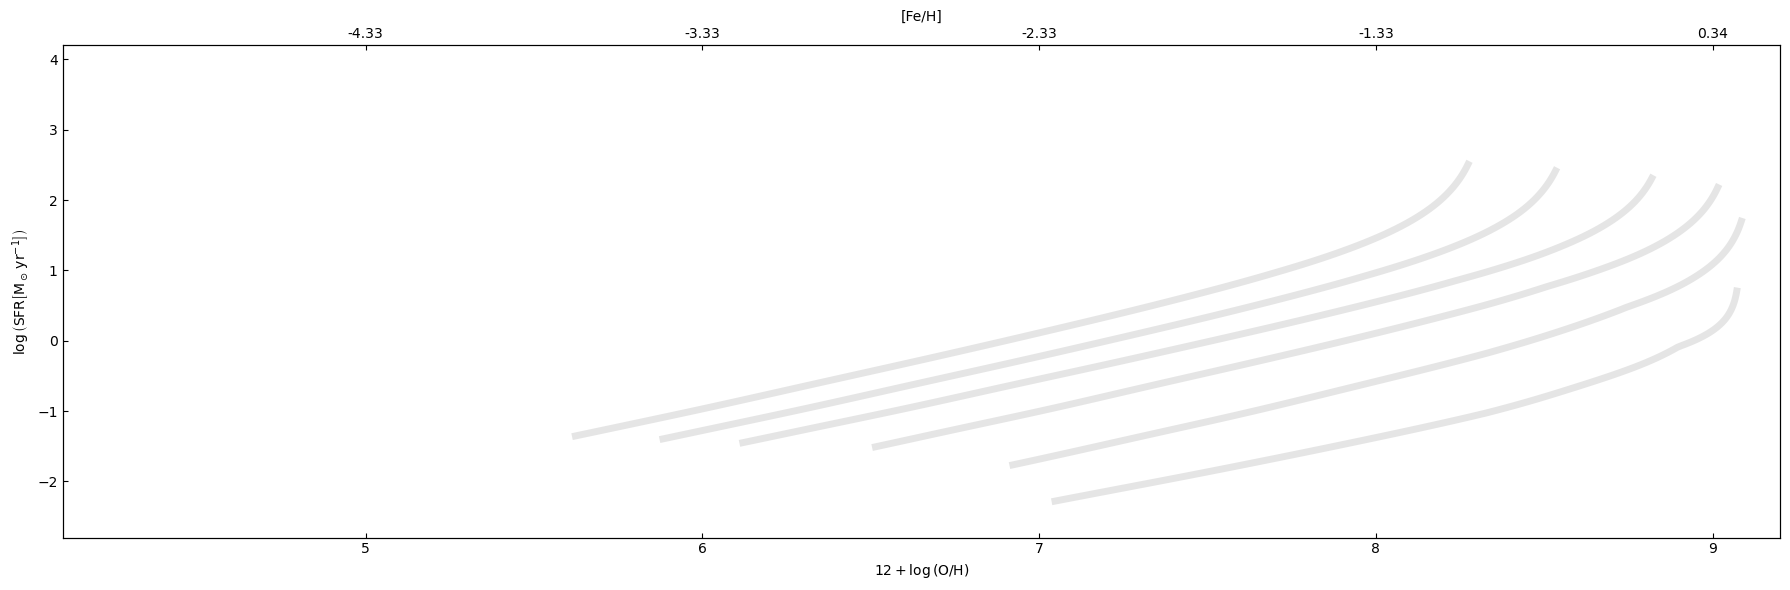

In [16]:
fig, ax = plt.subplots(figsize=(18,6), tight_layout=True)
zoh_minplot = 4.2
zoh_maxplot = 9.5
sfr_minplot = -2.8
sfr_maxplot = 4.2

for z, zohs, sfrs in zip(ref_zs, ref_zoh_list, ref_sfr_list):
    ax.plot(zohs, sfrs, '-', c='gray', lw=5, alpha=0.2)

ax.set_ylabel(r'$\log\left(\mathrm{SFR\left[\mathrm{M}_\odot\,\mathrm{yr}^{-1}\right]}\right)$')
ax.set_ylim(sfr_minplot, sfr_maxplot)

ax.set_xticks(np.arange(4,10,1))
ax.set_xlim(zoh_minplot-0.1, zoh_maxplot-0.3)
ax.set_xlabel(r'$12+\log\left(\mathrm{O/H}\right)$')

ax2 = ax.twiny()
ax2.set_xticks(np.arange(4,10,1))
ax2.set_xlim(zoh_minplot-0.1, zoh_maxplot-0.3)
ax2.set_xticklabels([f'{x:.2f}' for x in [ZOH_to_FeH(zoh) for zoh in np.arange(4,10,1)]])
ax2.set_xlabel('[Fe/H]')

ax.tick_params(axis='both', direction='in')
ax2.tick_params(axis='x', direction='in')

### Full plane

In [17]:
n_redshift = 19
redshift_min = 0
redshift_max = 18
force_boundary_redshift = False
logm_per_redshift = 100
logm_min = 6
logm_max = 12
mzr_model = MZR_option
sfmr_flattening = SFMR_option
gsmf_slope_fixed = GSMF_option
sampling_mode = 'uniform' # uniform, mass or number
scatter_model = 'none'
apply_igimf_corrections = True
random_state = 42

In [18]:
fullref_galaxysampling = GalaxyGrid(n_redshift,
                                    redshift_min,
                                    redshift_max,
                                    force_boundary_redshift,
                                    logm_per_redshift,
                                    logm_min, 
                                    logm_max, 
                                    mzr_model, 
                                    sfmr_flattening,
                                    gsmf_slope_fixed,
                                    sampling_mode,
                                    scatter_model,
                                    apply_igimf_corrections,
                                    random_state)

In [19]:
%%time
fullref_galaxysampling.get_grid()

CPU times: user 11.8 s, sys: 3.81 ms, total: 11.8 s
Wall time: 11.8 s


In [20]:
fullref_zs = fullref_galaxysampling.sample_redshift_array
fullref_zoh_list = fullref_galaxysampling.zoh_list
fullref_sfr_list = fullref_galaxysampling.sfr_list
fullref_log_gsmf_list = fullref_galaxysampling.log_gsmf_list

In [21]:
n_redshift = 100
redshift_min = 0
redshift_max = 18
force_boundary_redshift = False
logm_per_redshift = 100
logm_min = 6
logm_max = 12
mzr_model = MZR_option
sfmr_flattening = SFMR_option
gsmf_slope_fixed = GSMF_option
sampling_mode = 'uniform' # uniform, mass or number
scatter_model = 'none'
apply_igimf_corrections = True
random_state = 42

In [22]:
plane_galaxysampling = GalaxyGrid(n_redshift,
                            redshift_min,
                            redshift_max,
                            force_boundary_redshift,
                            logm_per_redshift,
                            logm_min, 
                            logm_max, 
                            mzr_model, 
                            sfmr_flattening,
                            gsmf_slope_fixed,
                            sampling_mode,
                            scatter_model,
                            apply_igimf_corrections,
                            random_state)

In [23]:
%%time
plane_galaxysampling.get_grid()

CPU times: user 1min 4s, sys: 7.93 ms, total: 1min 4s
Wall time: 1min 4s


In [24]:
plane_logm_bins = plane_galaxysampling.galaxy_sample.bin_limits
plane_logms = plane_galaxysampling.galaxy_sample.grid_logmasses
plane_zs = plane_galaxysampling.sample_redshift_array
plane_zoh_array = np.array(plane_galaxysampling.zoh_list)
plane_zoh_list = plane_galaxysampling.zoh_list
plane_sfr_array = np.array(plane_galaxysampling.sfr_list)
plane_sfr_list = plane_galaxysampling.sfr_list
plane_log_gsmf_list = plane_galaxysampling.log_gsmf_list
plane_log_gsmf_array = np.array(plane_log_gsmf_list)
plane_log_gsmf_max = np.concatenate(plane_log_gsmf_list).max()
plane_log_gsmf_min = np.concatenate(plane_log_gsmf_list).min()
planeg_log_gsmf_cnorm = plane_log_gsmf_max - plane_log_gsmf_min

In [25]:
plane_density_array = plane_galaxysampling.density_array
plane_ndensity_array = plane_galaxysampling.ndensity_array
plane_dzoh_lims_array = plane_galaxysampling.zoh_bin_array
plane_sample_redshift_array = plane_galaxysampling.sample_redshift_array

In [26]:
plane_logm_bin_size = np.array([np.log10(10**logm1 - 10**logm0) for logm0,logm1 in zip(plane_logm_bins[1:], plane_logm_bins[:-1])])

In [27]:
plane_mass_distr = 2*plane_logm_bin_size+plane_log_gsmf_list

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

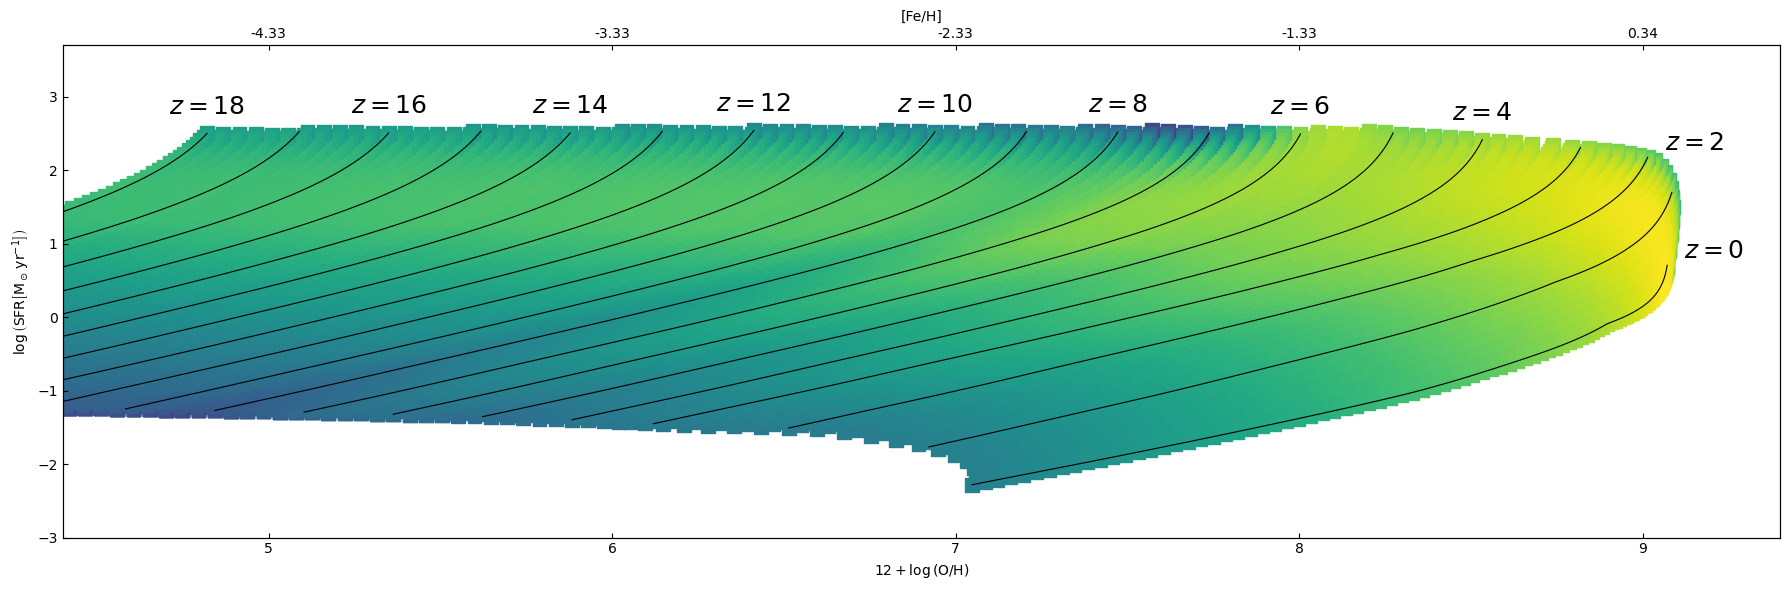

In [28]:
fig, ax = plt.subplots(figsize=(18,6), tight_layout=True)
zoh_minplot = 4.5
zoh_maxplot = 9.7
sfr_minplot = -3
sfr_maxplot = 3.7

plane_mass_min = np.concatenate(plane_mass_distr).min()
plane_mass_max = np.concatenate(plane_mass_distr).max()
plane_cnorm = plane_mass_max - plane_mass_min
for z, zohs, sfrs, mass in zip(plane_zs, plane_zoh_list, plane_sfr_list, plane_mass_distr):
    c = (mass - plane_mass_min) / plane_cnorm
    ax.scatter(zohs, sfrs, marker='s', c=c, cmap='viridis', s=100, vmin=0, vmax=1)
    #ax.text(zohs[-2]-0.2, sfrs[-2]-0.2, f'z={z:.2f}', fontsize=10)
    
for z, zohs, sfrs in zip(fullref_zs, fullref_zoh_list, fullref_sfr_list):
    ax.plot(zohs, sfrs, '-', c='k',  lw=0.8, alpha=1, label=z)
    if z%2 == 0:
        if z <= 2:
            ax.text(zohs[0]+0.05, sfrs[0]+0.2, f'$z={z:.0f}$', ha='left', va='center', fontsize=18)
        else:
            ax.text(zohs[0], sfrs[0]+0.2, f'$z={z:.0f}$', ha='center', va='bottom', fontsize=18)
            pass
    
ax.set_ylabel(r'$\log\left(\mathrm{SFR\left[\mathrm{M}_\odot\,\mathrm{yr}^{-1}\right]}\right)$')
ax.set_ylim(sfr_minplot, sfr_maxplot)

ax.set_xticks(np.arange(4,10,1))
ax.set_xlim(zoh_minplot-0.1, zoh_maxplot-0.3)
ax.set_xlabel(r'$12+\log\left(\mathrm{O/H}\right)$')

ax2 = ax.twiny()
ax2.set_xticks(np.arange(4,10,1))
ax2.set_xlim(zoh_minplot-0.1, zoh_maxplot-0.3)
ax2.set_xticklabels([f'{x:.2f}' for x in [ZOH_to_FeH(zoh) for zoh in np.arange(4,10,1)]])
ax2.set_xlabel('[Fe/H]')

ax.tick_params(axis='both', direction='in')
ax2.tick_params(axis='x', direction='in')

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=plane_mass_min, vmax=plane_mass_max))
cb = fig.colorbar(sm)
cb.set_label(r'$\log\left(\Delta M_{\ast,\mathrm{tot}}/\mathrm{M}_\odot\right)$')

plt.savefig(FIGURE_FOLDER/('sfrgrid_fullbg'+file_suffix+'.pdf'), bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/('sfrgrid_fullbg'+file_suffix+'.png'), bbox_inches='tight')

### Sample background

In [29]:
n_redshift = 10
redshift_min = 0
redshift_max = 10
force_boundary_redshift = False
logm_per_redshift = 200
logm_min = 6
logm_max = 12
mzr_model = MZR_option
sfmr_flattening = SFMR_option
gsmf_slope_fixed = GSMF_option
sampling_mode = 'uniform' # uniform, mass or number
scatter_model = 'none'
apply_igimf_corrections = True
random_state = 42

In [30]:
bg_galaxysampling = GalaxyGrid(n_redshift,
                            redshift_min,
                            redshift_max,
                            force_boundary_redshift,
                            logm_per_redshift,
                            logm_min, 
                            logm_max, 
                            mzr_model, 
                            sfmr_flattening,
                            gsmf_slope_fixed,
                            sampling_mode,
                            scatter_model,
                            apply_igimf_corrections,
                            random_state)

In [31]:
%%time
bg_galaxysampling.sample_redshift()

CPU times: user 1min 47s, sys: 3.98 ms, total: 1min 47s
Wall time: 1min 47s


In [32]:
%%time
bg_galaxysampling.get_grid()

CPU times: user 22.5 s, sys: 4 ms, total: 22.5 s
Wall time: 22.5 s


In [33]:
bg_logm_bins = bg_galaxysampling.galaxy_sample.bin_limits
bg_logms = bg_galaxysampling.galaxy_sample.grid_logmasses
bg_zs = bg_galaxysampling.sample_redshift_array
bg_zoh_array = np.array(bg_galaxysampling.zoh_list)
bg_zoh_list = bg_galaxysampling.zoh_list
bg_sfr_array = np.array(bg_galaxysampling.sfr_list)
bg_sfr_list = bg_galaxysampling.sfr_list
bg_log_gsmf_list = bg_galaxysampling.log_gsmf_list
bg_log_gsmf_array = np.array(bg_log_gsmf_list)
bg_log_gsmf_max = np.concatenate(bg_log_gsmf_list).max()
bg_log_gsmf_min = np.concatenate(bg_log_gsmf_list).min()
bg_log_gsmf_cnorm = bg_log_gsmf_max - bg_log_gsmf_min

In [34]:
bg_density_array = bg_galaxysampling.density_array
bg_ndensity_array = bg_galaxysampling.ndensity_array
bg_dzoh_lims_array = bg_galaxysampling.zoh_bin_array
bg_sample_redshift_array = bg_galaxysampling.sample_redshift_array

In [35]:
bg_logm_bin_size = np.array([np.log10(10**logm1 - 10**logm0) for logm0,logm1 in zip(bg_logm_bins[1:], bg_logm_bins[:-1])])

In [36]:
bg_mass_distr = 2*bg_logm_bin_size+bg_log_gsmf_list

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

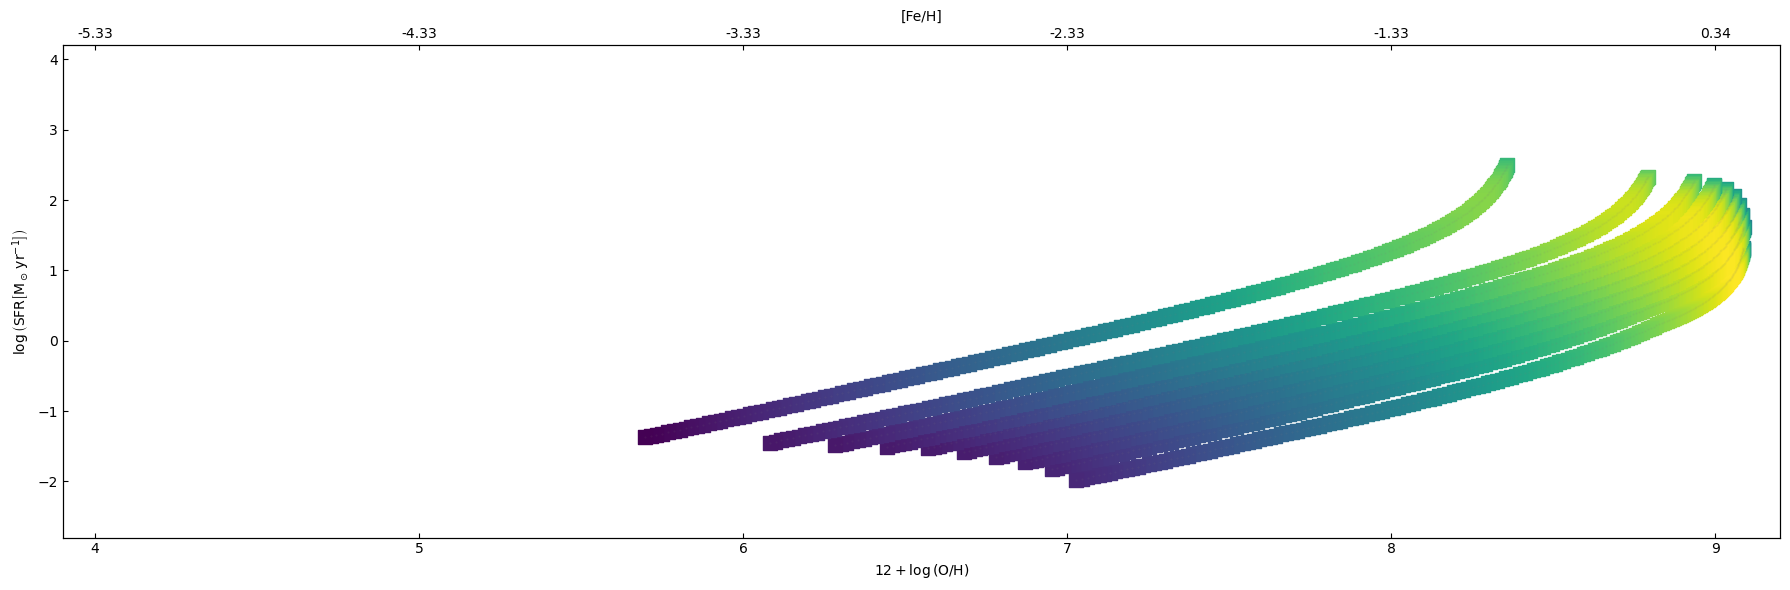

In [37]:
fig, ax = plt.subplots(figsize=(18,6), tight_layout=True)
zoh_minplot = 4
zoh_maxplot = 9.5
sfr_minplot = -2.8
sfr_maxplot = 4.2

for z, zohs, sfrs in zip(bg_zs, bg_zoh_array, bg_sfr_array):
    ax.plot(zohs, sfrs, '.', c='gray', markersize=1, lw=2, alpha=0.1)

bg_mass_min = np.concatenate(bg_mass_distr).min()
bg_mass_max = np.concatenate(bg_mass_distr).max()
bg_cnorm = bg_mass_max - bg_mass_min
for z, zohs, sfrs, mass in zip(bg_zs, bg_zoh_list, bg_sfr_list, bg_mass_distr):
    c = (mass - bg_mass_min) / bg_cnorm
    ax.scatter(zohs, sfrs, marker='s', c=c, cmap='viridis', s=100, vmin=0, vmax=1)
    #ax.text(zohs[-2]-0.2, sfrs[-2]-0.2, f'z={z:.2f}', fontsize=10)

ax.set_ylabel(r'$\log\left(\mathrm{SFR\left[\mathrm{M}_\odot\,\mathrm{yr}^{-1}\right]}\right)$')
ax.set_ylim(sfr_minplot, sfr_maxplot)

ax.set_xticks(np.arange(4,10,1))
ax.set_xlim(zoh_minplot-0.1, zoh_maxplot-0.3)
ax.set_xlabel(r'$12+\log\left(\mathrm{O/H}\right)$')

ax2 = ax.twiny()
ax2.set_xticks(np.arange(4,10,1))
ax2.set_xlim(zoh_minplot-0.1, zoh_maxplot-0.3)
ax2.set_xticklabels([f'{x:.2f}' for x in [ZOH_to_FeH(zoh) for zoh in np.arange(4,10,1)]])
ax2.set_xlabel('[Fe/H]')

ax.tick_params(axis='both', direction='in')
ax2.tick_params(axis='x', direction='in')

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=bg_mass_min, vmax=bg_mass_max))
cb = fig.colorbar(sm)
cb.set_label(r'$\log\left(\Delta M_{\ast,\mathrm{tot}}/\mathrm{M}_\odot\right)$')

plt.savefig(FIGURE_FOLDER/('sfrgrid_samplebg'+file_suffix+'.pdf'), bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/('sfrgrid_samplebg'+file_suffix+'.png'), bbox_inches='tight')

#### Metallicity plot

In [38]:
feh_array = np.empty(bg_zoh_array.shape, np.float64)
for i, row in enumerate(bg_zoh_array):
    for j, zoh in enumerate(row):
        feh = ZOH_to_FeH(zoh)
        feh_array[i,j] = feh

In [39]:
dFeH_lims_array = np.empty(bg_dzoh_lims_array.shape, np.float64)
dFeH_array = np.empty((bg_dzoh_lims_array.shape[0], bg_dzoh_lims_array.shape[1]-1), np.float64)

for i, row in enumerate(bg_dzoh_lims_array):
    for j, zoh in enumerate(row):
        FeH = ZOH_to_FeH(zoh)
        dFeH_lims_array[i,j] = FeH
        
for i, row in enumerate(dFeH_lims_array):
    for j, (FeH1, FeH2) in enumerate(zip(row[:-1], row[1:])):
        dFeH = np.abs(FeH2 - FeH1)
        dFeH_array[i,j] = dFeH

In [40]:
dndFeH_array = np.divide(bg_density_array, dFeH_array)

In [41]:
dNdFeH_array = np.empty(dndFeH_array.shape, np.float64)

for i, (z, row) in enumerate(zip(bg_sample_redshift_array, dndFeH_array)):
    dVc = (4*np.pi*u.sr * cosmo.differential_comoving_volume(z)).value
    for j, dndFeH in enumerate(row):
        dNdFeH = dndFeH * dVc
        dNdFeH_array[i,j] = dNdFeH

In [42]:
normalized_dNdFeH_array = np.empty(dNdFeH_array.shape, np.float64)

for i, (row, dFeH_lims) in enumerate(zip(dNdFeH_array, dFeH_lims_array)):
    intt = 0
    for dNdFeH, llim, ulim in zip(row, dFeH_lims[:-1], dFeH_lims[1:]):
        dFeH = np.abs(ulim - llim)
        dN = dNdFeH * dFeH
        intt += dN
    normalized_row = row / row.sum()
    if intt != 0:
        normalized_row = row / intt
    normalized_dNdFeH_array[i] = normalized_row

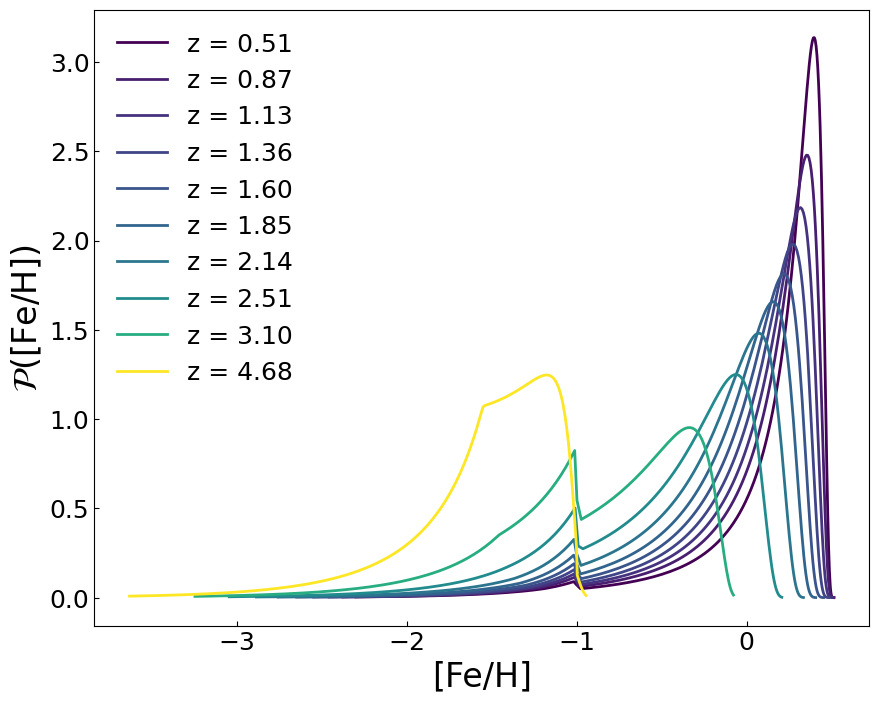

In [43]:
fig, ax = plt.subplots(figsize=(10,8))
dNdFeH_plot_cnorm = bg_sample_redshift_array.max() - bg_sample_redshift_array.min()

for z, fehs, dNdFeHs in zip(bg_sample_redshift_array, feh_array, normalized_dNdFeH_array):
    color = cm.viridis((z-bg_sample_redshift_array.min())/dNdFeH_plot_cnorm)
    ax.plot(fehs, dNdFeHs, '-', c=color, label=f'z = {z:.2f}', lw=2, markersize=16)
    
ax.set_xlabel('[Fe/H]', fontsize=24)
ax.set_ylabel(r'$\mathcal{P}\left(\mathrm{[Fe/H]}\right)$', fontsize=24)
ax.tick_params(axis='both', direction='in', labelsize=18)
    
ax.legend(loc='upper left', frameon=False, fontsize=18)

plt.savefig(FIGURE_FOLDER/('metdistr_sample'+file_suffix+'.pdf'), bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/('metdistr_sample'+file_suffix+'.png'), bbox_inches='tight')

# Sample grid

In [64]:
%%time
galaxysampling.get_grid()

CPU times: user 35.1 s, sys: 8 ms, total: 35.2 s
Wall time: 35.2 s


<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\o'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_52062/2156301429.py:36: SyntaxWarning: invalid escape sequence '\,'
  ax.text(zoh+0.01, -2.8, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', c='orange', fontsize=18)
/tmp/ipykernel_52062/2156301429.py:36: SyntaxWarning: invalid escape sequence '\o'
  ax.text(zoh+0.01, -2.8, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', c='orange', fontsize=18)


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

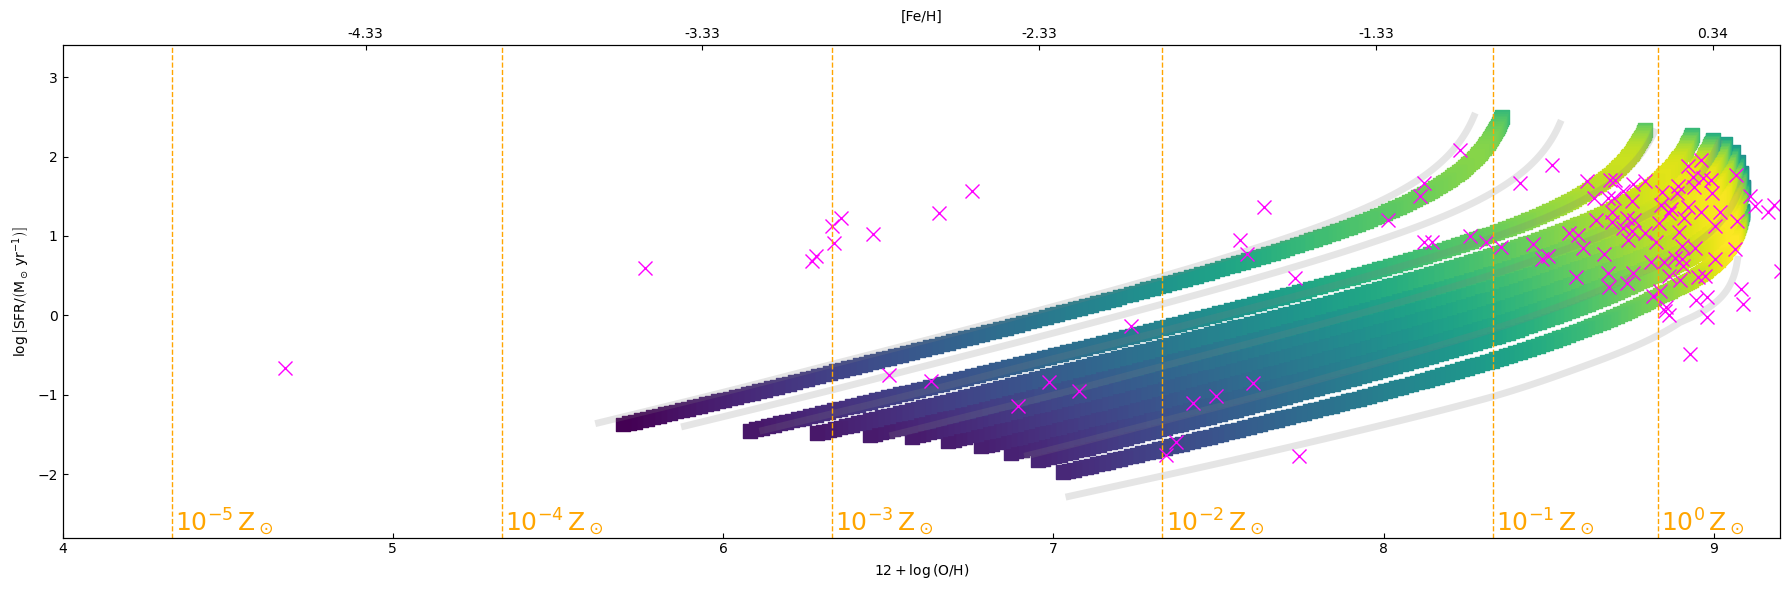

In [65]:
zoh_list = galaxysampling.zoh_list
feh_list = galaxysampling.feh_list
sfr_list = galaxysampling.sfr_list
log_gsmf_list = galaxysampling.log_gsmf_list
gsmf_list = [10.**log_gsmf for log_gsmf in log_gsmf_list]
mass_list = galaxysampling.mass_list
sample_redshift_array = galaxysampling.sample_redshift_array

fig, ax = plt.subplots(figsize=(18,6), tight_layout=True)
zoh_minplot = 4.2
zoh_maxplot = 9.5
sfr_minplot = -2.8
sfr_maxplot = 4.2
z_cnorm = sample_redshift_array.max() - sample_redshift_array.min()

for z, zohs, sfrs in zip(ref_zs, ref_zoh_list, ref_sfr_list):
    ax.plot(zohs, sfrs, '-', c='gray', lw=5, alpha=0.2)
    
bg_mass_min = np.concatenate(bg_mass_distr).min()
bg_mass_max = np.concatenate(bg_mass_distr).max()
bg_cnorm = bg_mass_max - bg_mass_min
for z, zohs, sfrs, mass in zip(bg_zs, bg_zoh_list, bg_sfr_list, bg_mass_distr):
    c = (mass - bg_mass_min) / bg_cnorm
    ax.scatter(zohs, sfrs, marker='s', c=c, cmap='viridis', s=100, vmin=0, vmax=1)

grid_descr = ''
for z, masses, zohs, sfrs in zip(sample_redshift_array, mass_list, zoh_list, sfr_list):
    color = cm.jet((z-sample_redshift_array.min())/z_cnorm)
    ax.plot(zohs, sfrs, 'x', c='magenta', markersize=10, lw=2)
    line = ''.join([r'$\log\left(M_i/M_\odot\right)$ = {}'.format(masses)]+[' \n'])
    grid_descr += line
    
for feh in np.arange(-5, 1, 1):
    zoh = ZOH_from_FeH(feh)
    ax.vlines(zoh, -3, 5, linestyle='--', color='orange', linewidth=1)
    ax.text(zoh+0.01, -2.8, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', c='orange', fontsize=18)
    
ax.set_ylabel(r'$\log\left[\mathrm{SFR}/\left(\mathrm{M}_\odot\,\mathrm{yr}^{-1}\right)\right]$')
ax.set_ylim(sfr_minplot, sfr_maxplot-0.8)

ax.set_xticks(np.arange(4,10,1))
ax.set_xlim(zoh_minplot-0.2, zoh_maxplot-0.3)
ax.set_xlabel(r'$12+\log\left(\mathrm{O/H}\right)$')

ax2 = ax.twiny()
ax2.set_xticks(np.arange(4,10,1))
ax2.set_xlim(zoh_minplot-0.1, zoh_maxplot-0.3)
ax2.set_xticklabels([f'{x:.2f}' for x in [ZOH_to_FeH(zoh) for zoh in np.arange(4,10,1)]])
ax2.set_xlabel('[Fe/H]')

ax.tick_params(axis='both', direction='in')
ax2.tick_params(axis='x', direction='in')

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=bg_mass_min, vmax=bg_mass_max))
cb = fig.colorbar(sm)
cb.set_label(r'$\log\left(\Delta M_{\ast,\mathrm{tot}}/\mathrm{M}_\odot\right)$')

In [66]:
cm_cubehelix = sns.cubehelix_palette(as_cmap=True)

NameError: name 'sns' is not defined

<>:22: SyntaxWarning: invalid escape sequence '\,'
<>:22: SyntaxWarning: invalid escape sequence '\o'
<>:22: SyntaxWarning: invalid escape sequence '\,'
<>:22: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_52062/476230350.py:22: SyntaxWarning: invalid escape sequence '\,'
  ax.text(zoh+0.01, sfr_minplot, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', color='orange', fontsize=22)
/tmp/ipykernel_52062/476230350.py:22: SyntaxWarning: invalid escape sequence '\o'
  ax.text(zoh+0.01, sfr_minplot, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', color='orange', fontsize=22)


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

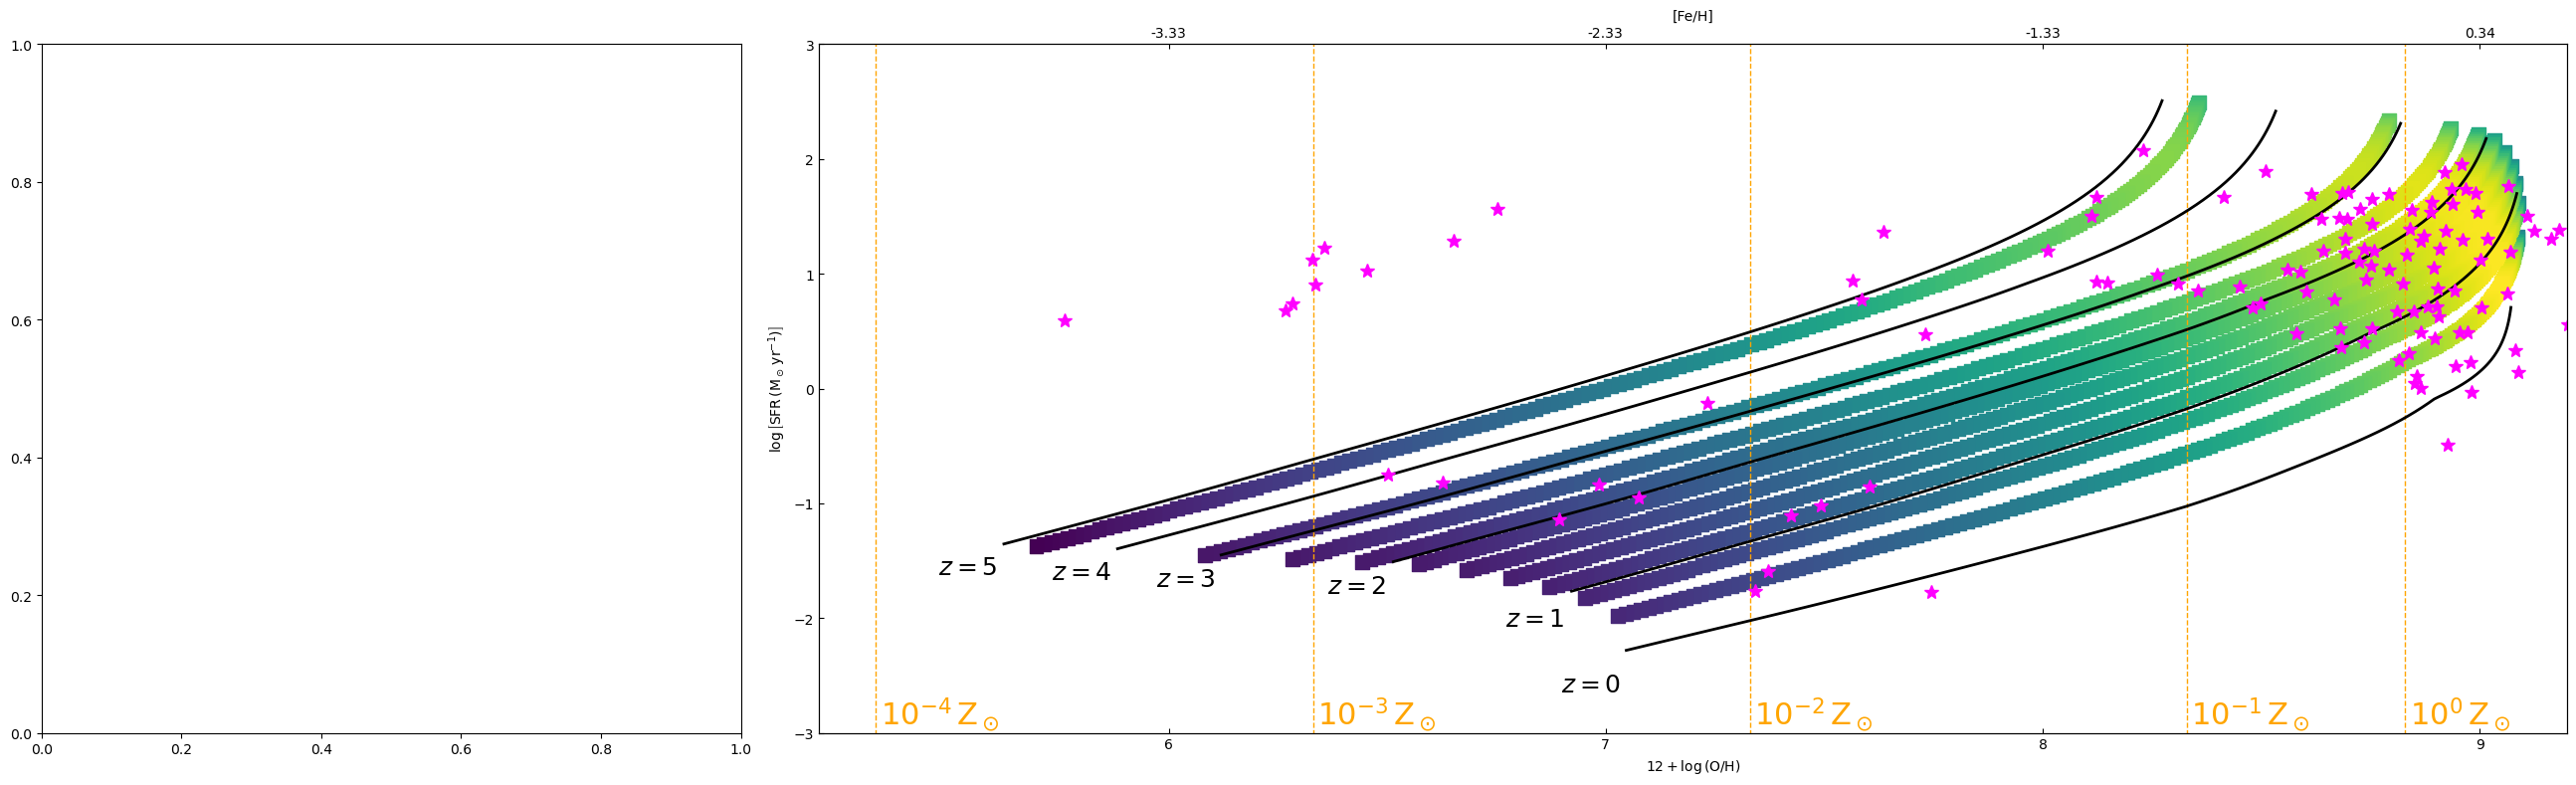

In [67]:
zoh_minplot = 5.2
zoh_maxplot = 9.2
sfr_minplot = -3
sfr_maxplot = 3

fig, (ax3, ax) = plt.subplots(1, 2, figsize=(26, 8), tight_layout=True, gridspec_kw={'width_ratios': [2, 5]})
rect = fig.patch
rect.set_facecolor('white')

    
bg_mass_min = np.concatenate(bg_mass_distr).min()
bg_mass_max = np.concatenate(bg_mass_distr).max()
bg_cnorm = bg_mass_max - bg_mass_min
for z, zohs, sfrs, mass in zip(bg_zs, bg_zoh_list, bg_sfr_list, bg_mass_distr):
    c = (mass - bg_mass_min) / bg_cnorm
    ax.scatter(zohs, sfrs, marker='s', c=c, cmap='viridis', s=100, vmin=0, vmax=1)


for feh in np.arange(-4, 1, 1):
    zoh = ZOH_from_FeH(feh)
    ax.vlines(zoh, -5, 5, linestyle='--', color='orange', linewidth=1)
    ax.text(zoh+0.01, sfr_minplot, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', color='orange', fontsize=22)

for z, zohs, sfrs in zip(ref_zs, ref_zoh_list, ref_sfr_list):
    ax.plot(zohs, sfrs, '-', c='k', lw=2, alpha=1)
    if z!= 6:
        ax.text(zohs[-2]-0.05, 1.1*(sfrs[-2]), f'$z={z:.0f}$', ha='right', va='top', fontsize=18)
    else:
        ax.text(zohs[-2], sfrs[-2]+0.2, f'$z={z:.0f}$', ha='left', va='bottom', fontsize=18)
        
for z, masses, zohs, sfrs in zip(sample_redshift_array, mass_list, zoh_list, sfr_list):
    ax.plot(zohs, sfrs, '*', c='magenta', markersize=10, lw=2)
    
ax.set_ylabel(r'$\log\left[\mathrm{SFR}\,(\mathrm{M}_\odot\,\mathrm{yr}^{-1})\right]$')
ax.set_ylim(sfr_minplot, sfr_maxplot)

ax.set_xticks(np.arange(4,10,1))
ax.set_xlim(zoh_minplot, zoh_maxplot)
ax.set_xlabel(r'$12+\log\left(\mathrm{O/H}\right)$')

ax2 = ax.twiny()
ax2.set_xticks(np.arange(4,10,1))
ax2.set_xlim(zoh_minplot, zoh_maxplot)
ax2.set_xticklabels([f'{x:.2f}' for x in [ZOH_to_FeH(zoh) for zoh in np.arange(4,10,1)]])
ax2.set_xlabel('[Fe/H]')

ax.tick_params(axis='both', direction='in')
ax2.tick_params(axis='x', direction='in')

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=bg_mass_min, vmax=bg_mass_max))
cb = fig.colorbar(sm)
cb.set_label(r'$\log\left(\Delta M_{\ast,\mathrm{tot}}/\mathrm{M}_\odot\right)$')

dNdFeH_plot_cnorm = sample_redshift_array.max() - sample_redshift_array.min()

zi = 0
for z, fehs, dNdFeHs in zip(sample_redshift_array[::1], feh_array[::1], normalized_dNdFeH_array[::1]):
    color = cm_cubehelix(zi/len(sample_redshift_array[::1]))
    ax3.plot(fehs, dNdFeHs, '-', c=color, label=f'z = {z:.2f}', lw=3, markersize=16)
    zi += 1
    
ax3.set_xlabel('[Fe/H]')
ax3.set_ylabel(r'$\mathcal{P}\left(\mathrm{[Fe/H]}\right)$')
ax3.tick_params(axis='both', direction='in')
    
ax3.legend(loc='upper left', frameon=False, ncol=2)
ax3.set_xlim(-3, 0.6)
ax3.set_ylim(0, 3.5)

plt.savefig(FIGURE_FOLDER/('10z10Z_midmet_grid_partialbg'+file_suffix+'.png'), bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/('10z10Z_midmet_grid_partialbg'+file_suffix+'.pdf'), bbox_inches='tight')

#### Alternative: full SFR-Z plane background

<>:33: SyntaxWarning: invalid escape sequence '\,'
<>:33: SyntaxWarning: invalid escape sequence '\o'
<>:33: SyntaxWarning: invalid escape sequence '\,'
<>:33: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_52062/673565685.py:33: SyntaxWarning: invalid escape sequence '\,'
  ax.text(zoh+0.01, sfr_minplot, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', color='orange', fontsize=22)
/tmp/ipykernel_52062/673565685.py:33: SyntaxWarning: invalid escape sequence '\o'
  ax.text(zoh+0.01, sfr_minplot, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', color='orange', fontsize=22)


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

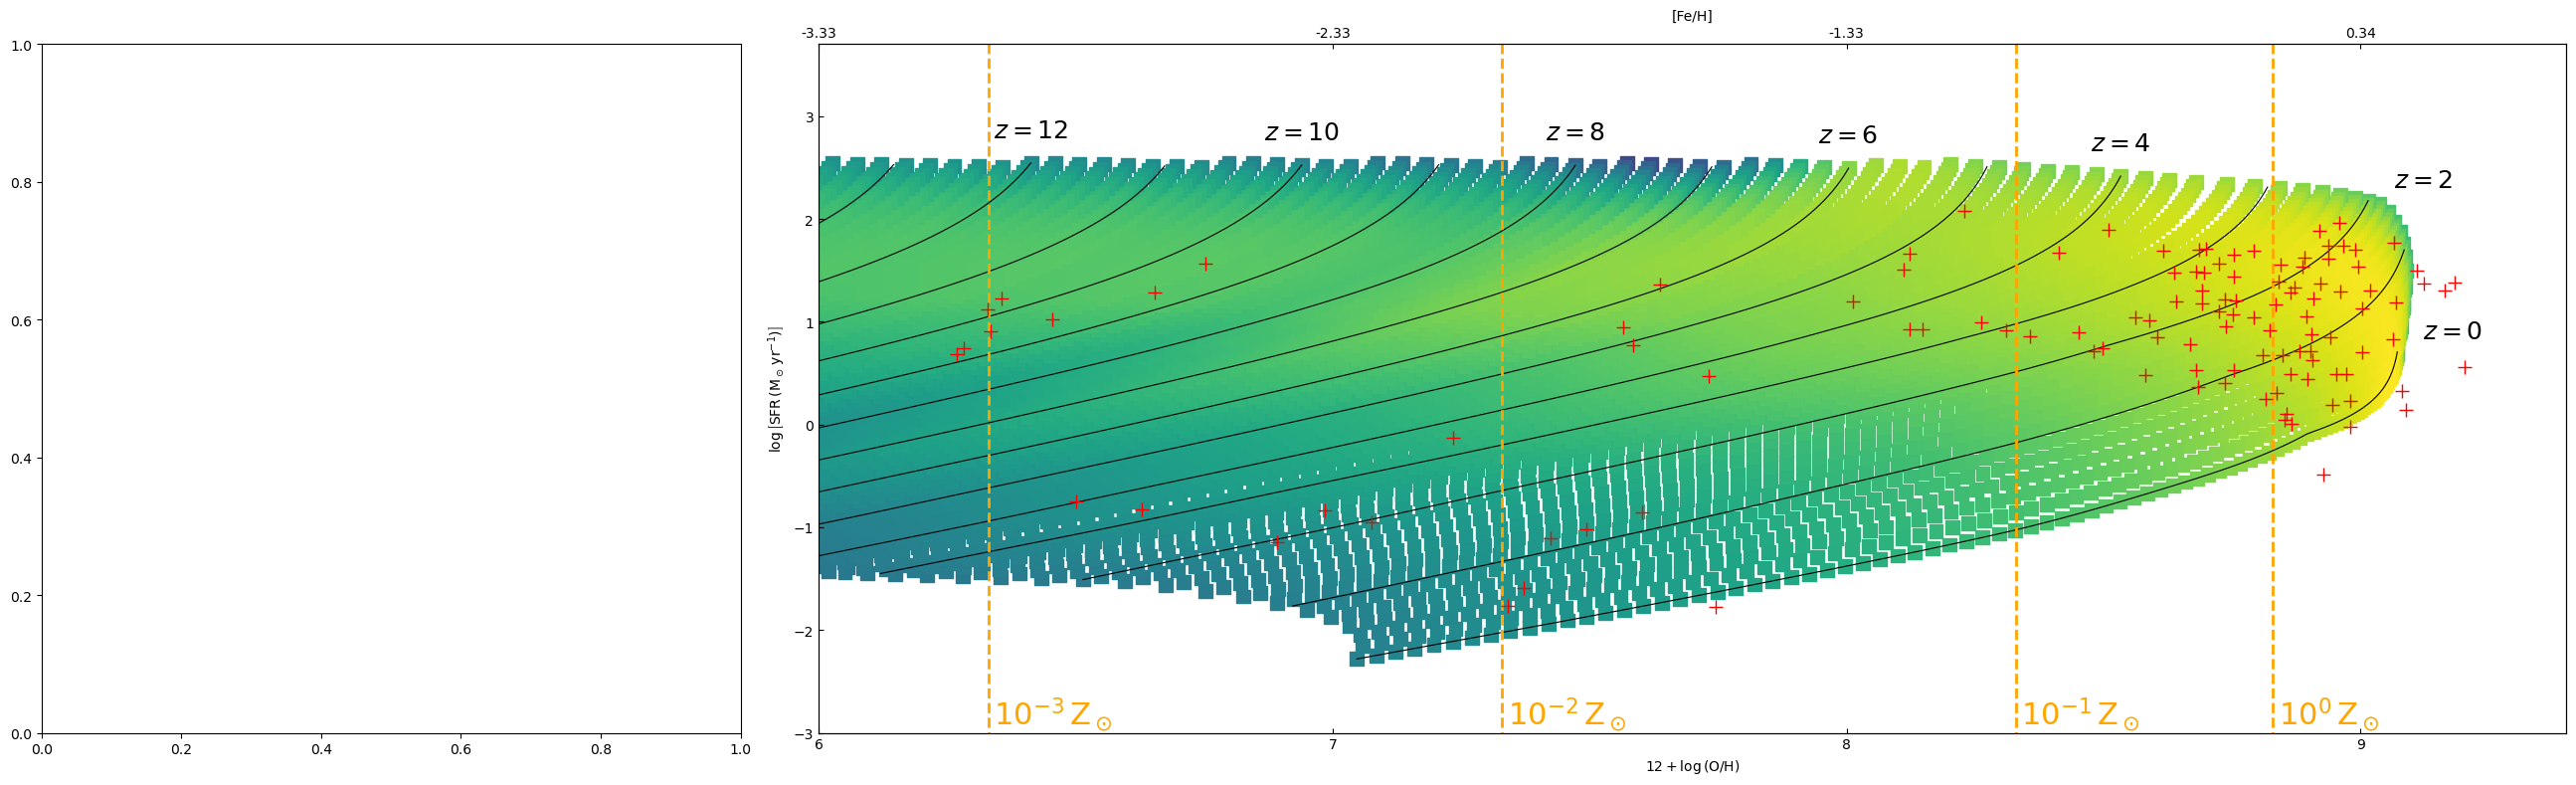

In [68]:
zoh_minplot = 6
zoh_maxplot = 9.4
sfr_minplot = -3
sfr_maxplot = 3.7

fig, (ax3, ax) = plt.subplots(1, 2, figsize=(26, 8), tight_layout=True, gridspec_kw={'width_ratios': [2, 5]})
rect = fig.patch
rect.set_facecolor('white')

plane_mass_min = np.concatenate(plane_mass_distr).min()
plane_mass_max = np.concatenate(plane_mass_distr).max()
plane_cnorm = plane_mass_max - plane_mass_min
for z, zohs, sfrs, mass in zip(plane_zs, plane_zoh_list, plane_sfr_list, plane_mass_distr):
    c = (mass - plane_mass_min) / plane_cnorm
    ax.scatter(zohs, sfrs, marker='s', c=c, cmap='viridis', s=100, vmin=0, vmax=1)
    #xx, yy = np.meshgrid(zohs, sfrs)
    #cc = np.meshgrid(c,c)[0]
    #ax.pcolormesh(xx, yy, cc.T, cmap='viridis', vmin=0, vmax=1)
    #ax.text(zohs[-2]-0.2, sfrs[-2]-0.2, f'z={z:.2f}', fontsize=10)
    
for z, zohs, sfrs in zip(fullref_zs, fullref_zoh_list, fullref_sfr_list):
    ax.plot(zohs, sfrs, '-', c='k',  lw=0.8, alpha=1, label=z)
    if z%2 == 0:
        if z <= 2:
            ax.text(zohs[0]+0.05, sfrs[0]+0.2, f'$z={z:.0f}$', ha='left', va='center', fontsize=18)
        elif z <= 13:
            ax.text(zohs[0], sfrs[0]+0.2, f'$z={z:.0f}$', ha='center', va='bottom', fontsize=18)
        else:
            pass
for feh in np.arange(-3, 1, 1):
    zoh = ZOH_from_FeH(feh)
    ax.vlines(zoh, -5, 5, linestyle='--', color='orange', linewidth=2)
    ax.text(zoh+0.01, sfr_minplot, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', color='orange', fontsize=22)
    
for z, masses, zohs, sfrs in zip(sample_redshift_array, mass_list, zoh_list, sfr_list):
    ax.plot(zohs, sfrs, '+', c='r', markersize=10, lw=2)

    
ax.set_ylabel(r'$\log\left[\mathrm{SFR}\,(\mathrm{M}_\odot\,\mathrm{yr}^{-1})\right]$')
ax.set_ylim(sfr_minplot, sfr_maxplot)

ax.set_xticks(np.arange(4,10,1))
ax.set_xlim(zoh_minplot, zoh_maxplot)
ax.set_xlabel(r'$12+\log\left(\mathrm{O/H}\right)$')

ax2 = ax.twiny()
ax2.set_xticks(np.arange(4,10,1))
ax2.set_xlim(zoh_minplot, zoh_maxplot)
ax2.set_xticklabels([f'{x:.2f}' for x in [ZOH_to_FeH(zoh) for zoh in np.arange(4,10,1)]])
ax2.set_xlabel('[Fe/H]')

ax.tick_params(axis='both', direction='in')
ax2.tick_params(axis='x', direction='in')

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=bg_mass_min, vmax=bg_mass_max))
cb = fig.colorbar(sm)
cb.set_label(r'$\log\left(\Delta M_{\ast,\mathrm{tot}}/\mathrm{M}_\odot\right)$')

dNdFeH_plot_cnorm = sample_redshift_array.max() - sample_redshift_array.min()

zi = 0
for z, fehs, dNdFeHs in zip(sample_redshift_array[::1], feh_array[::1], normalized_dNdFeH_array[::1]):
    color = cm_cubehelix(zi/len(sample_redshift_array[::1]))
    ax3.plot(fehs, dNdFeHs, '-', c=color, label=f'z = {z:.2f}', lw=3, markersize=16)
    zi += 1
    
ax3.set_xlabel('[Fe/H]')
ax3.set_ylabel(r'$\mathcal{P}\left(\mathrm{[Fe/H]}\right)$')
ax3.tick_params(axis='both', direction='in')
    
ax3.legend(loc='upper left', frameon=False, ncol=2)
ax3.set_xlim(-3, 0.6)
ax3.set_ylim(0, 3.5)

plt.savefig(FIGURE_FOLDER/('10z10Z_midmet_grid_fullbg'+file_suffix+'.png'), bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/('10z10Z_midmet_grid_fullbg'+file_suffix+'.pdf'), bbox_inches='tight')

In [49]:
fullref_zs

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18.])

<>:35: SyntaxWarning: invalid escape sequence '\,'
<>:35: SyntaxWarning: invalid escape sequence '\o'
<>:35: SyntaxWarning: invalid escape sequence '\,'
<>:35: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_52062/148279091.py:35: SyntaxWarning: invalid escape sequence '\,'
  ax.text(zoh+0.01, sfr_minplot, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', color='orange', fontsize=22)
/tmp/ipykernel_52062/148279091.py:35: SyntaxWarning: invalid escape sequence '\o'
  ax.text(zoh+0.01, sfr_minplot, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', color='orange', fontsize=22)
/tmp/ipykernel_52062/148279091.py:35: SyntaxWarning: invalid escape sequence '\,'
  ax.text(zoh+0.01, sfr_minplot, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', color='orange', fontsize=22)
/tmp/ipykernel_52062/148279091.py:35: SyntaxWarning: invalid escape sequence '\o'
  ax.text(zoh+0.01, sfr_minplot, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left

NameError: name 'sample_redshift_array' is not defined

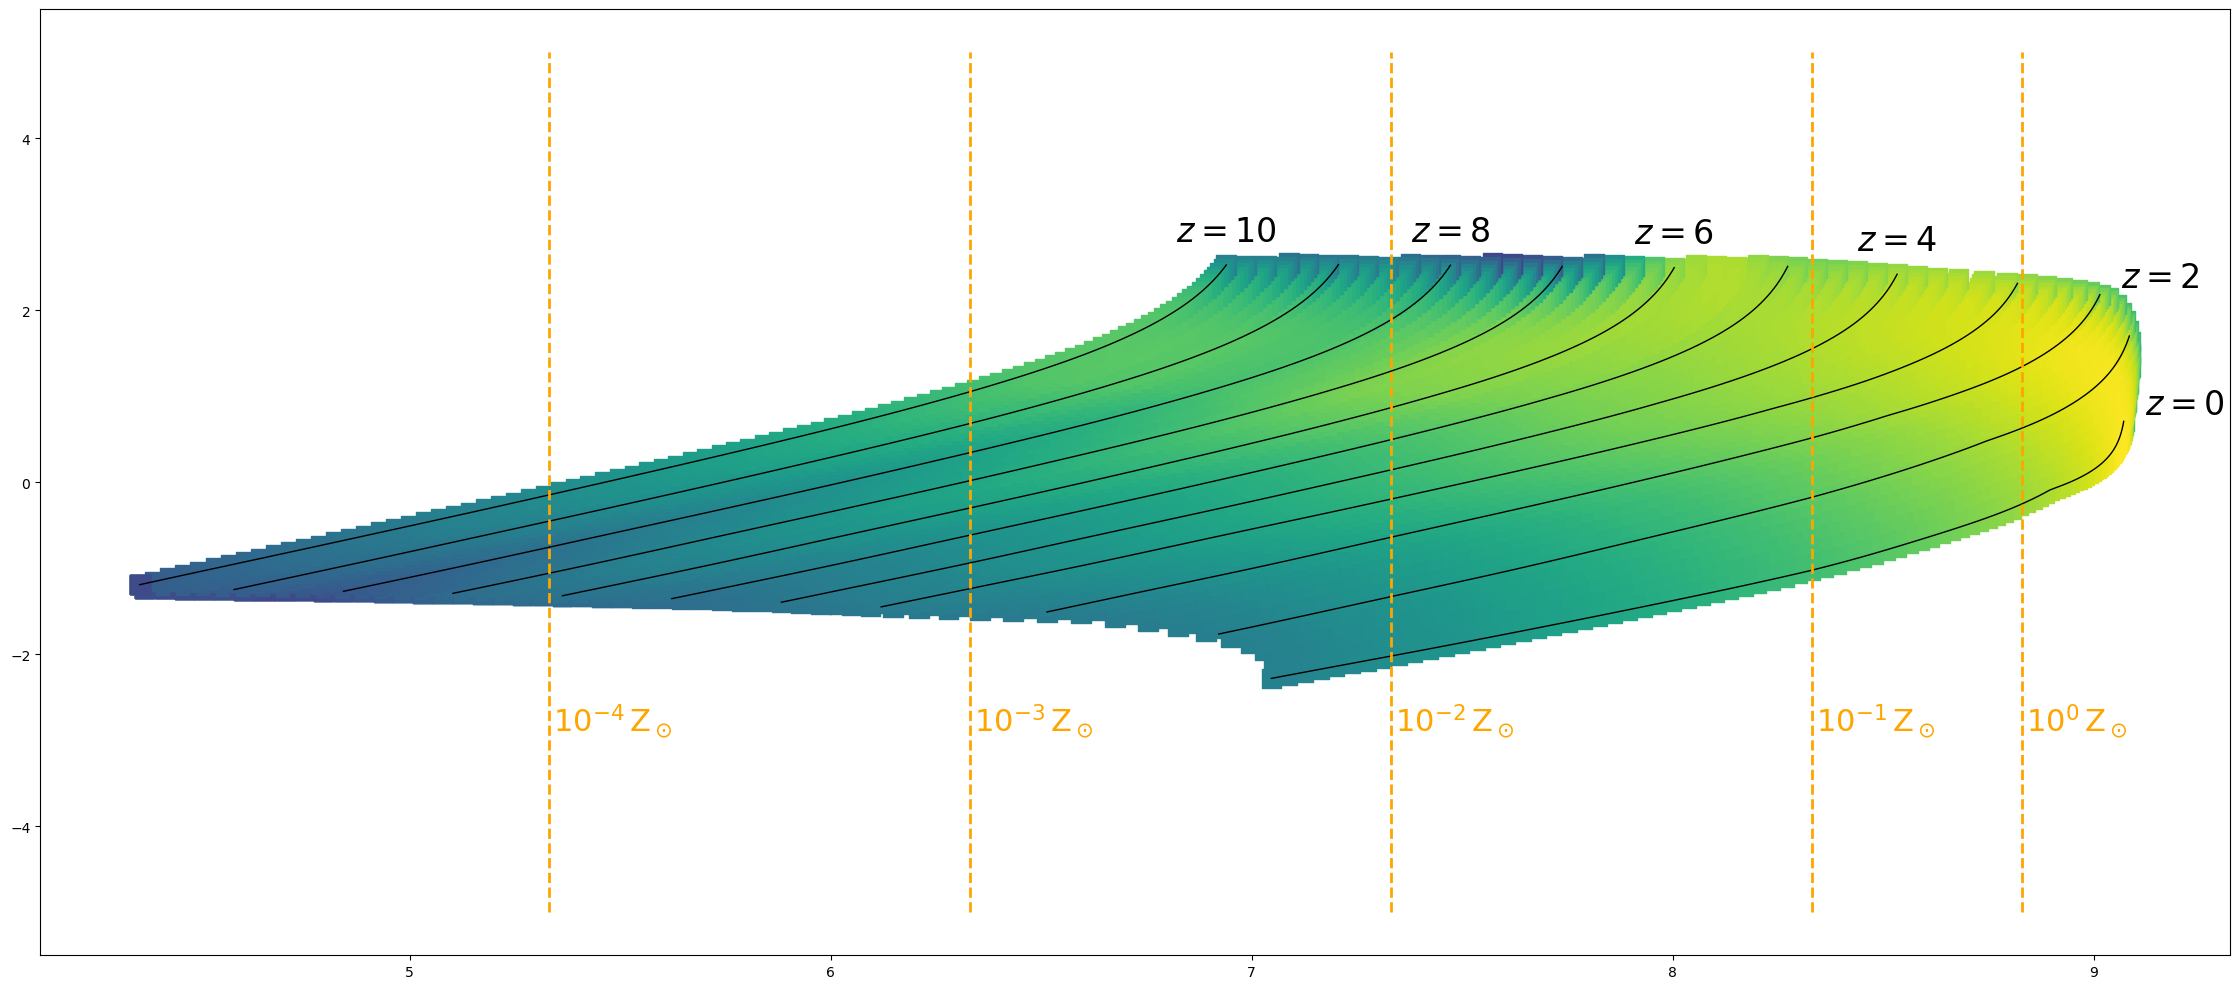

In [50]:
zoh_minplot = 4.3
zoh_maxplot = 9.4
sfr_minplot = -3
sfr_maxplot = 3.7

fig, ax = plt.subplots(figsize=(22.5, 10), tight_layout=True)
rect = fig.patch
rect.set_facecolor('white')

plane_mass_min = np.concatenate(plane_mass_distr).min()
plane_mass_max = np.concatenate(plane_mass_distr).max()
plane_cnorm = plane_mass_max - plane_mass_min
for z, zohs, sfrs, mass in zip(plane_zs, plane_zoh_list, plane_sfr_list, plane_mass_distr):
    if z<= 10:
        c = (mass - plane_mass_min) / plane_cnorm
        ax.scatter(zohs, sfrs, marker='s', c=c, cmap='viridis', s=200, vmin=0, vmax=1)
    #xx, yy = np.meshgrid(zohs, sfrs)
    #cc = np.meshgrid(c,c)[0]
    #ax.pcolormesh(xx, yy, cc.T, cmap='viridis', vmin=0, vmax=1)
    #ax.text(zohs[-2]-0.2, sfrs[-2]-0.2, f'z={z:.2f}', fontsize=10)
    
for z, zohs, sfrs in zip(fullref_zs, fullref_zoh_list, fullref_sfr_list):
    if z<=10:
        ax.plot(zohs, sfrs, '-', c='k',  lw=1, alpha=1, label=z)
    if z%2 == 0:
        if z <= 2:
            ax.text(zohs[0]+0.05, sfrs[0]+0.2, f'$z={z:.0f}$', ha='left', va='center', fontsize=24)
        elif z <= 10:
            ax.text(zohs[0], sfrs[0]+0.2, f'$z={z:.0f}$', ha='center', va='bottom', fontsize=24)
        else:
            pass
for feh in np.arange(-4, 1, 1):
    zoh = ZOH_from_FeH(feh)
    ax.vlines(zoh, -5, 5, linestyle='--', color='orange', linewidth=2)
    ax.text(zoh+0.01, sfr_minplot, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', color='orange', fontsize=22)
    
for z, masses, zohs, sfrs in zip(sample_redshift_array, mass_list, zoh_list, sfr_list):
    ax.plot(zohs, sfrs, '+', c='r', markersize=14, lw=2)

    
ax.set_ylabel(r'$\log\left[\mathrm{SFR}\,(\mathrm{M}_\odot\,\mathrm{yr}^{-1})\right]$')
ax.set_ylim(sfr_minplot, sfr_maxplot)

ax.set_xticks(np.arange(4,10,1))
ax.set_xlim(zoh_minplot, zoh_maxplot)
ax.set_xlabel(r'$12+\log\left(\mathrm{O/H}\right)$')

ax2 = ax.twiny()
ax2.set_xticks(np.arange(4,10,1))
ax2.set_xlim(zoh_minplot, zoh_maxplot)
ax2.set_xticklabels([f'{x:.2f}' for x in [ZOH_to_FeH(zoh) for zoh in np.arange(4,10,1)]])
ax2.set_xlabel('[Fe/H]')

ax.tick_params(axis='both', direction='in')
ax2.tick_params(axis='x', direction='in')

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=bg_mass_min, vmax=bg_mass_max))
cb = fig.colorbar(sm)
cb.set_label(r'$\log\left(\Delta M_{\ast,\mathrm{tot}}/\mathrm{M}_\odot\right)$')


plt.savefig(FIGURE_FOLDER/('10z10Z_midmet_grid_fullbg_nomet'+file_suffix+'.png'), bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/('10z10Z_midmet_grid_fullbg_nomet'+file_suffix+'.pdf'), bbox_inches='tight')

# Saving the grid

In [51]:
#GRIDFILE = Path(GALAXYGRID_DIR_PATH, 'sfrgrid_midmet_10z_plusbound_10met_final.pkl')

In [ ]:
redshift_bin_edges_list = [(lower_edge, upper_edge) for lower_edge, upper_edge in zip(galaxysampling.sample_redshift_quantiles[:-1], galaxysampling.sample_redshift_quantiles[1:])]

In [ ]:
zoh_bin_edges_list = []

for arr in galaxysampling.zoh_bin_array:
    bins = [(lower_edge, upper_edge) for lower_edge, upper_edge in zip(arr[:-1], arr[1:])]
    zoh_bin_edges_list.append(bins)    

In [ ]:
grid_array

In [ ]:
pd.DataFrame([grid_list])

In [ ]:
n_columns = 6 # redshift, galaxy mass, density, sfr, zoh, feh
#columns = ['Redshift_ZAMS', 'Log_Mgal', 'Log(Number density [Mpc-3 Msun-1])', 'Log(SFR [Msun yr-1])', '12+log(O/H)', '[Fe/H]', 'Redshift_Bin_Edges', '']
columns = ['Redshift_ZAMS', 'Redshift_Bin_Edges', 'Log_Mgal', 'Log_n_dens', 'Log_SFR', 'ZOH', 'ZOH_Bin_Edges', 'FeH']

#grid_array = np.empty((0, n_columns), np.float64)
grid_df = pd.DataFrame(columns=columns)
for z, z_bin, masses, densities, sfrs, zohs, zoh_bins, fehs in zip(sample_redshift_array, redshift_bin_edges_list, mass_list, gsmf_list,  sfr_list, zoh_list, zoh_bin_edges_list, feh_list):
    lines = np.array([masses, densities, sfrs, zohs, zoh_bins, fehs], 'object').T
    
    for line in lines:
        grid_list = [[np.float32(z)] + [z_bin] + list(line)]
        df = pd.DataFrame(grid_list, columns=columns)
        grid_df = pd.concat([grid_df, df])
#grid_df = pd.DataFrame(grid_array, columns=columns)
grid_df.reset_index(inplace=True, drop=True)

In [ ]:
grid_df.Redshift_ZAMS = grid_df.Redshift_ZAMS.astype('float32')
grid_df.Log_Mgal = grid_df.Log_Mgal.astype('float32')
grid_df.Log_n_dens = grid_df.Log_n_dens.astype('float32')
grid_df.Log_SFR = grid_df.Log_SFR.astype('float32')
grid_df.ZOH = grid_df.ZOH.astype('float32')
grid_df.FeH = grid_df.FeH.astype('float32')

In [ ]:
grid_df.memory_usage(deep=True).sum()/1024  #kb

In [ ]:
grid_df.describe()

In [ ]:
with plt.rc_context({'axes.labelsize': 12}):
    sns.pairplot(grid_df, hue='Redshift_ZAMS')

In [ ]:
grid_df.to_pickle(GRIDFILE)

In [ ]:
sfrd_grid = pd.read_pickle(GRIDFILE)

In [ ]:
sfrd_grid.info()

In [ ]:
for redshift in sfrd_grid.Redshift_ZAMS.unique():
    df = sfrd_grid[sfrd_grid.Redshift_ZAMS == redshift]
    for feh in df.FeH:
        print(feh)
    print('')